In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns

In [4]:
test_labels = pd.read_csv('test_labels.csv')
print(test_labels.shape)
test_labels.head(2)

(153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1


In [5]:
test_labels = test_labels[(test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
print(test_labels.shape)
test_labels.head(2)

(63978, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0


In [6]:
df_test = pd.read_csv('test_ml.csv')
print(df_test.shape)
df_test.head(2)

(153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [7]:
# merge with an inner join
test = pd.merge(test_labels, df_test, on='id', how='inner')
print(test.shape)
test.head(2)

(63978, 8)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.


In [8]:
train = pd.read_csv('train_ml.csv')
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [8]:
# check the number of records
print('The dataset contains', train.shape[0], 'records and', train.shape[1], 'columns.')

The dataset contains 159571 records and 8 columns.


In [9]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values.')

The dataset has 0 missing values.


In [10]:

print('The dataset has', train.duplicated().sum(), 'duplicates.')

The dataset has 0 duplicates.


In [12]:
train['comment_text'][4]
train['comment_text'][13]
train['comment_text'][1392]

'"\nCondolences to you, your wife and family...my prayers are with you..  ☥  "'

In [13]:
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

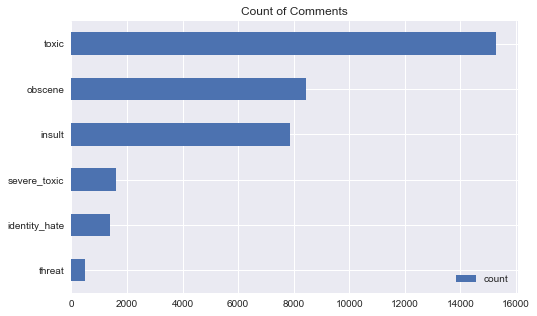

In [14]:
# to_frame() converts series to DataFrame
frequency = train[columns].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
frequency.plot.barh(y='count', title='Count of Comments', figsize=(8, 5));

In [15]:
train.groupby(columns).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'}).head(15)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


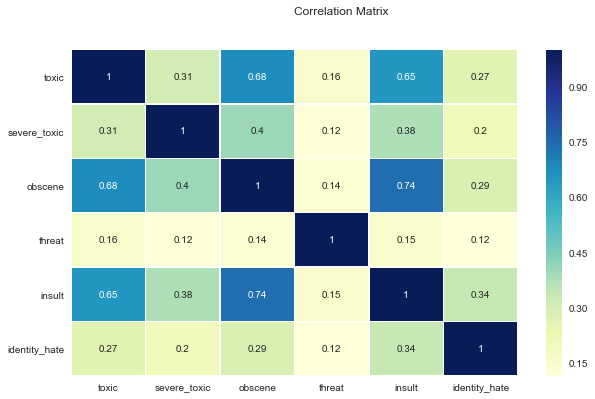

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train[columns].corr(), annot=True, cmap="YlGnBu", linewidths=.5, ax=ax);

In [20]:
# import necessary libraries
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('stopwords')
import re
import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aneri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [21]:
# define an empty dictionary
word_counter = {}

# writing a clean_text function
def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

In [22]:
for col in columns:    
    text = Counter()        
    
    # ... applying the clean-function to each column's comments and ...
    train[train[col] == 1]['comment_text'].apply(lambda t: text.update(clean_text(t).split()))
    
    # ... combining all to one dataframe
    word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

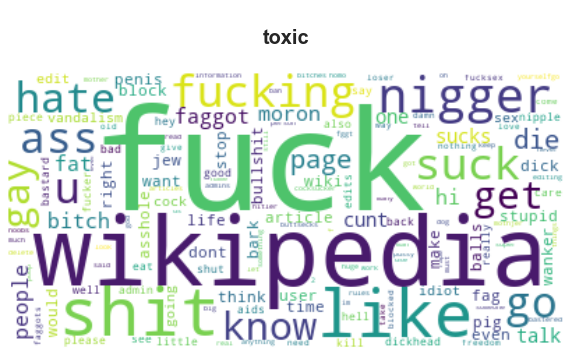

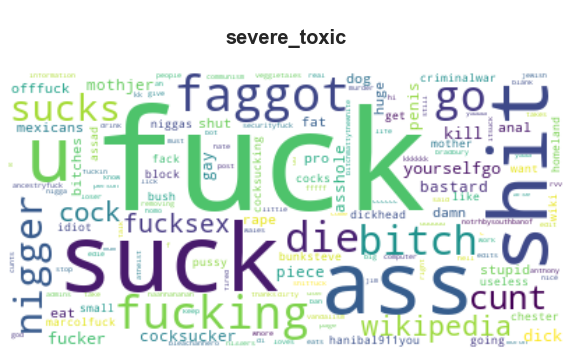

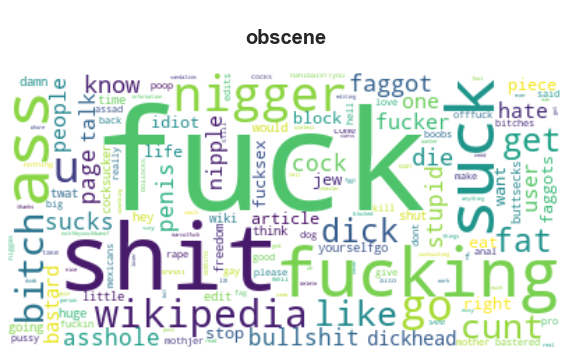

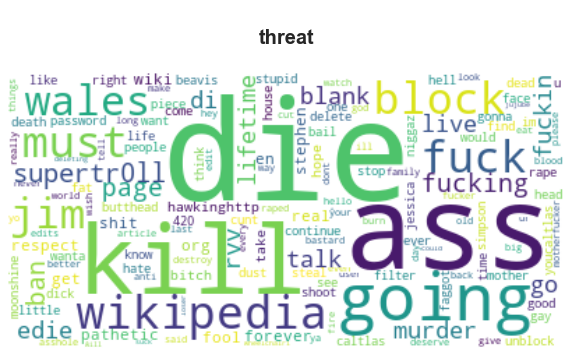

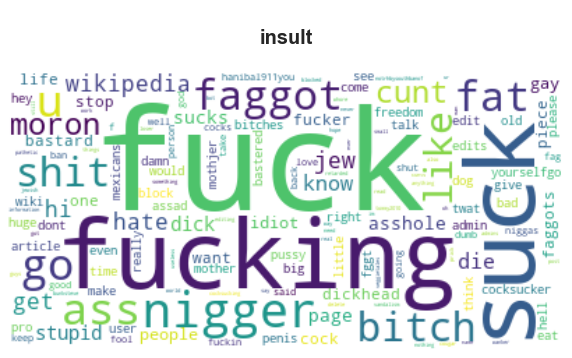

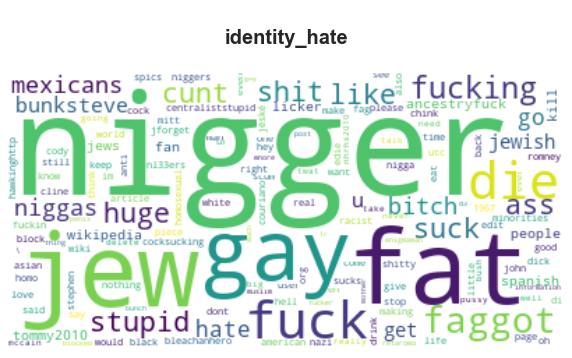

In [23]:
# iterating through new df word_counter and creating a WordCloud for each column
for col in word_counter:    
    wc_list = word_counter[col]
    
    wordcloud = WordCloud(background_color='white', max_words=150, max_font_size=100, random_state=4)\
                          .generate_from_frequencies(wc_list.to_dict()['count'])

    fig = plt.figure(figsize=(10, 8))
    plt.title('\n' + col + '\n', fontsize=20, fontweight='bold')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

In [16]:
X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [17]:
# tokenizing the data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

# turning the tokenized text into sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

# padding the sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63978, 200)


In [18]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

In [10]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

In [30]:
base_model = Sequential()

# add embedding layer 
base_model.add(Embedding(input_dim=max_features, input_length=max_len,
                         output_dim=embedding_dims))

# add pooling layer 
# ... which will extract features from the embeddings of all words in the comment
base_model.add(GlobalMaxPool1D())

# add dense layer to produce an output dimension of 50 and apply relu activation
base_model.add(Dense(50, activation='relu'))

# Large neural nets trained on relatively small datasets can overfit the training data.
# set the regularizing dropout layer to drop out 30% of the nodes, dropout is a simple way to reduce the overfitting
base_model.add(Dropout(0.3))

In [31]:
# finally add a dense layer
# ... which projects output into six units and squash it with sigmoid activation
base_model.add(Dense(6, activation='sigmoid'))

In [32]:
base_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(0.01), metrics=['accuracy'])

# check the model with all our layers
base_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,566,756
Trainable params: 2,566,756
Non-trainable params: 0
_________________________________________________________________


In [33]:
base_hist = base_model.fit(X_train, y_train, batch_size=32, 
                           epochs=3, validation_split=0.1)


Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 332s 2ms/step - loss: 0.0678 - accuracy: 0.9779 - val_loss: 0.0561 - val_accuracy: 0.9804
Epoch 2/3
143613/143613 [==============================] - 291s 2ms/step - loss: 0.0560 - accuracy: 0.9800 - val_loss: 0.0567 - val_accuracy: 0.9807
Epoch 3/3
143613/143613 [==============================] - 298s 2ms/step - loss: 0.0538 - accuracy: 0.9801 - val_loss: 0.0572 - val_accuracy: 0.9814


In [34]:
# evaluate the algorithm on the test dataset
base_test_loss, base_test_auc = base_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', base_test_loss)
print('Test Accuracy:', base_test_auc)

63978/63978 [==============================] - 4s 60us/step
Test Loss:     0.07704714468011781
Test Accuracy: 0.96662437915802


In [36]:
# instantiate CNN model
cnn_model = Sequential()

# add embedding layer 
cnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))
 
# set the dropout layer # instantiate CNN model
cnn_model = Sequential()

# add embedding layer 
cnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))
 
# set the dropout layer to drop out 50% of the nodes
cnn_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
cnn_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
cnn_model.add(BatchNormalization()) #to drop out 50% of the nodes
cnn_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
cnn_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
cnn_model.add(BatchNormalization())

In [37]:
# add pooling layer 
cnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
cnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
cnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
cnn_model.add(Dense(6, activation='sigmoid'))

In [38]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          40100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 100)         

In [39]:
cnn_hist = cnn_model.fit(X_train, y_train, batch_size=32, 
                         epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1337s 9ms/step - loss: 0.0738 - accuracy: 0.9763 - val_loss: 0.0550 - val_accuracy: 0.9801
Epoch 2/3
143613/143613 [==============================] - 1212s 8ms/step - loss: 0.0569 - accuracy: 0.9798 - val_loss: 0.0588 - val_accuracy: 0.9799
Epoch 3/3
143613/143613 [==============================] - 1086s 8ms/step - loss: 0.0536 - accuracy: 0.9806 - val_loss: 0.0589 - val_accuracy: 0.9802


In [40]:
cnn_test_loss, cnn_test_auc = cnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', cnn_test_loss)
print('Test Accuracy:', cnn_test_auc)

63978/63978 [==============================] - 136s 2ms/step
Test Loss:     0.07139946328526554
Test Accuracy: 0.9727581143379211


In [2]:
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.5))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer

NameError: name 'Sequential' is not defined

In [3]:
rnn_model.add(Dense(6, activation='sigmoid'))

NameError: name 'rnn_model' is not defined

In [4]:
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

rnn_model.summary()

NameError: name 'rnn_model' is not defined

In [1]:
rnn_hist = rnn_model.fit(X_train, y_train, batch_size=32, 
                          epochs=3, validation_split=0.1)

NameError: name 'rnn_model' is not defined

In [ ]:
rnn_test_loss, rnn_test_auc = rnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', rnn_test_loss)
print('Test Accuracy:', rnn_test_auc)

In [ ]:
# concat all training, validation and testing accuracy scores
accuracy_nn = ['Plain NN', 
               np.mean(base_hist.history['acc']), 
               np.mean(base_hist.history['val_acc']), 
               base_test_auc]

accuracy_cnn = ['CNN', 
                np.mean(cnn_hist.history['acc']), 
                np.mean(cnn_hist.history['val_acc']), 
                cnn_test_auc]

accuracy_rnn = ['RNN', 
                np.mean(rnn_hist.history['acc']), 
                np.mean(rnn_hist.history['val_acc']), 
                rnn_test_auc]

In [ ]:
# beautify the new dataframe
comparison.columns = ['Algorithm', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
comparison.set_index(['Algorithm'], inplace=True)
comparison